In [1]:
!pip install opencv-python matplotlib seaborn scikit-learn tensorflow

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

2025-09-18 19:19:38.360088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758223178.557329      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758223178.617126      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMG_SIZE = 128
DATA_PATH = "/kaggle/input/waste-classifier-02/west"

image_set, label_set = [], []

# Function to process a single image
def process_image(img):
    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Convert RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    # Normalize using ResNet preprocessing
    img = preprocess_input(img.astype("float32"))
    return img

# Load dataset
for class_name in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        fpath = os.path.join(class_path, fname)
        try:
            img = cv2.imread(fpath)
            if img is None:
                continue
            image_set.append(process_image(img))
            label_set.append(class_name)
        except Exception as err:
            print(f"[WARN] Skipped {fpath} - {err}")

# Convert to arrays
X_data = np.asarray(image_set, dtype="float32")
y_labels = np.asarray(label_set)

# Encode class labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)
y_onehot = to_categorical(y_encoded)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_onehot,
    test_size=0.2,
    stratify=y_onehot,
    random_state=42
)

print(f"[INFO] Training samples: {X_train.shape[0]}")
print(f"[INFO] Testing samples: {X_test.shape[0]}")
print(f"[INFO] Classes: {encoder.classes_}")

[INFO] Training samples: 3720
[INFO] Testing samples: 930
[INFO] Classes: ['battery' 'glass' 'metal' 'organic' 'paper' 'plastic']


In [ ]:
import matplotlib.pyplot as plt

# Pick an index to visualize
idx = 100

plt.imshow(X_train[idx].astype("uint8"))
plt.title(f"Label: {encoder.inverse_transform([np.argmax(y_train[idx])])[0]}")
plt.axis("off")
plt.show()


In [ ]:
import pandas as pd

pd.Series(
    encoder.inverse_transform(np.argmax(y_train, axis=1))
).value_counts().plot(kind="bar")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentation
aug_train = ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# For validation/test set
aug_test = ImageDataGenerator()

# Create data generators
train_loader = aug_train.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

test_loader = aug_test.flow(
    X_test, y_test,
    batch_size=32,
    shuffle=False
)


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
out = Dense(y_train.shape[1], activation="softmax")(x)

model_resnet = Model(inputs=base_model.input, outputs=out)

model_resnet.compile(optimizer=Adam(1e-3),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("resnet50_best.keras", save_best_only=True, monitor="val_accuracy")
]

history_resnet = model_resnet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=12,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/12


I0000 00:00:1758223231.214203     106 service.cc:148] XLA service 0x7bf8a008c240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758223231.214952     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758223232.588593     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/117 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1286 - loss: 3.3578

I0000 00:00:1758223235.786580     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.5234 - loss: 1.6582 - val_accuracy: 0.8559 - val_loss: 0.4031 - learning_rate: 0.0010
Epoch 2/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8257 - loss: 0.5176 - val_accuracy: 0.8914 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 3/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8688 - loss: 0.3872 - val_accuracy: 0.8968 - val_loss: 0.3016 - learning_rate: 0.0010
Epoch 4/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8904 - loss: 0.3027 - val_accuracy: 0.9032 - val_loss: 0.2701 - learning_rate: 0.0010
Epoch 5/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9028 - loss: 0.2779 - val_accuracy: 0.9011 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 6/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9064 - loss: 0.2654 - val_accuracy: 0.9097 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 7/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9181 - loss: 0.2332 - va

In [9]:
# Hyperparameter tuning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resnet(lr=1e-3, dropout=0.5):
    base = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(dropout)(x)
    out = Dense(y_train.shape[1], activation="softmax")(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(lr), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

param_list = [(1e-3, 0.5), (1e-4, 0.3)]
models = {}


In [10]:
# Train models
from tensorflow.keras.callbacks import EarlyStopping

for i, (lr, dr) in enumerate(param_list, 1):
    print(f"Training Model_{i} | LR={lr}, Dropout={dr}")
    model = build_resnet(lr, dr)
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=12,
        batch_size=32,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=1
    )
    models[f"Model_{i}"] = (model, hist)


Training Model_1 | LR=0.001, Dropout=0.5
Epoch 1/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.5338 - loss: 1.5816 - val_accuracy: 0.8763 - val_loss: 0.3533
Epoch 2/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8316 - loss: 0.4996 - val_accuracy: 0.9043 - val_loss: 0.3014
Epoch 3/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8764 - loss: 0.3569 - val_accuracy: 0.8968 - val_loss: 0.2805
Epoch 4/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8949 - loss: 0.3070 - val_accuracy: 0.9065 - val_loss: 0.2861
Epoch 5/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9048 - loss: 0.2558 - val_accuracy: 0.9129 - val_loss: 0.2673
Epoch 6/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9135 - loss: 0.2397 - val_accuracy: 0.9161 - val_loss: 0.2579
Epoch 7/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9235 - loss: 0.2271 - val_accuracy: 0.9194 - val_loss: 0.2510
Epoch 8/12
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step -

In [11]:
# Select best model
model_final, history_final = models["Model_1"]

In [12]:
# Evaluate
loss, acc = model_final.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

Test Accuracy: 0.9194, Test Loss: 0.2510


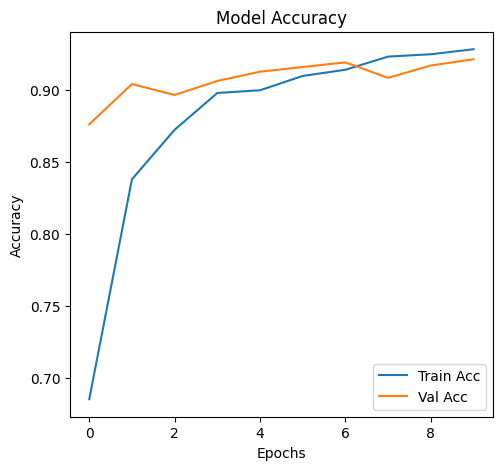

In [13]:
# Accuracy curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_final.history["accuracy"], label="Train Acc")
plt.plot(history_final.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

     battery       0.94      0.97      0.96       155
       glass       0.87      0.89      0.88       155
       metal       0.89      0.89      0.89       155
     organic       0.97      0.99      0.98       155
       paper       0.93      0.95      0.94       155
     plastic       0.91      0.82      0.86       155

    accuracy                           0.92       930
   macro avg       0.92      0.92      0.92       930
weighted avg       0.92      0.92      0.92       930



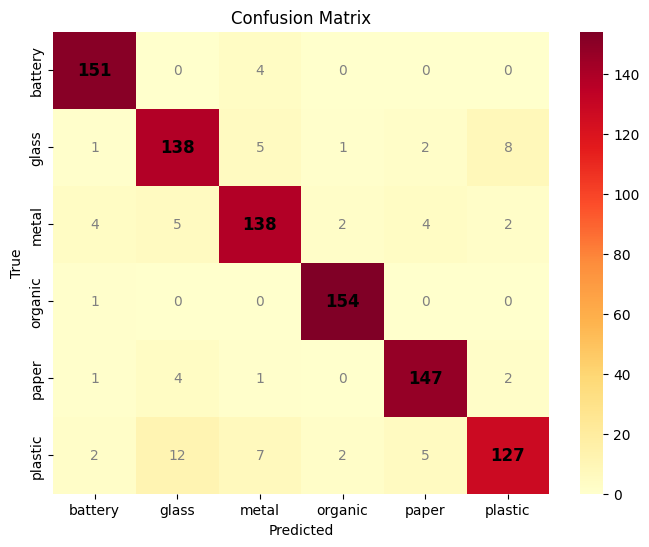

In [17]:
# Classification Report and Heatmap
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = model_final.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Report
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="YlOrRd",
                 xticklabels=encoder.classes_,
                 yticklabels=encoder.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            ax.text(j+0.5, i+0.5, cm[i, j],
                    ha="center", va="center",
                    color="black", fontsize=12, fontweight="bold")
        else: 
            ax.text(j+0.5, i+0.5, cm[i, j],
                    ha="center", va="center",
                    color="gray", fontsize=10)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [23]:
import os

print(os.listdir("/kaggle/working"))


['resnet50_best.keras', '.virtual_documents', 'models.zip']


In [24]:
model.save("/kaggle/working/resnet50_best.h5")


In [26]:
import zipfile
from IPython.display import FileLink
import os

with zipfile.ZipFile("models.zip", "w") as zipf:
    zipf.write("/kaggle/working/resnet50_best.h5", arcname="resnet50_best.h5")


FileLink("models.zip")


/kaggle/working/models.zip